<a href="https://colab.research.google.com/github/shradhautk/AI-MICROSCOPY-WORKSHOP/blob/main/DL_for_Microscopy_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-c9ze7ura
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-c9ze7ura
  Resolved https://github.com/pycroscopy/atomai to commit 6d187296074143d017ca8fc60302364cd946b180
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 42.3 MB/s eta 0:00:00
  Created wheel for atomai: filename=atomai-0.7.8-py3-none-any.whl size=162558 sha256=62879e0abf2a3a26e95738c5a746779bc9725b5b8b6f128d2c987ea2ff6f0bab
  Stored in directory: /tmp/pip-ephem-wheel-cac

Import modules:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import torch

It is important to normalize pixels to between 0 and 1 for training with a neural network. Here is a simple function for normalization of a single image:

In [ ]:
def norm2D(img):
    return (img - np.amin(img))/np.ptp(img)

Download training image and label from GitHub. Mount Google Drive or use `!gdown` instead to access images on Google Drive. Augmentation has to be performed on both images and labels to ensure correspondance.

In [ ]:
# Training image 1
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_1.npy'
# Training .xml label 1
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Lab_1.xml'
# Training U-Net mask 1
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_1_unet_mask.npy'
# Training image 2
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_2.npy'
# Training U-Net mask 2
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_1_unet_mask.npy'
# Training .xml label 2
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Lab_2.xml'

--2023-06-05 16:34:54--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_1.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048704 (1.0M) [application/octet-stream]
Saving to: ‘DL_for_Microscopy_Train_Img_1.npy.2’

DL_for_Microscopy_T 100%[===================>]   1.00M  --.-KB/s    in 0.03s   

2023-06-05 16:34:54 (37.6 MB/s) - ‘DL_for_Microscopy_Train_Img_1.npy.2’ saved [1048704/1048704]

--2023-06-05 16:34:54--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Lab_1.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110

Load, normalize, and show the training image and labels with size 512 by 512.

In [ ]:
# A function to generate a stack of images:
def get_imgs(file_list):
    imgs_ = []
    for name in file_list:
        imgs_.append(norm2D(plt.imread(name)))
    # move last axis to 1st so that 1st axis is no. of imgs
    return np.moveaxis(np.dstack(imgs_), -1, 0)

**Create a python list of your training images filenames here:**

In [ ]:
# Change the filenames of this list to your training data:
#train_img_names = ['DL_for_Microscopy_Train_Img_1.png', 'DL_for_Microscopy_Train_Img_2.png']

# Generate a stack of training images:
#train_imgs = get_imgs(train_img_names)

# Show the training imgs:
#fig, ax = plt.subplots(1, len(train_imgs))
#for i in range(len(train_imgs)):
#    ax[i].imshow(train_imgs[i], cmap='gist_gray')

Define functions for cropping:

In [ ]:
class cropper:
    """
    Augments an input image-mask pair by performing image cropping procedure
    """
    def __init__(self, image, mask, window_size, step_size):
        """
        Args:
            image (2d ndarray): image to be cropped (height x width),
            mask (3d ndarray): mask/ground truth (height x width x channels),
            window_size (tuple): width and height of sliding window,
            step_size (float): step size of sliding window,
            batch_size (int): number of images to return.
        """
        if np.ndim(image) == 2:
            image = np.expand_dims(image, axis=2)
        self.image = image
        if np.ndim(mask) == 2:
            mask = np.expand_dims(mask, axis=2)
        self.mask = mask
        self.window_size = window_size
        self.step_size = step_size
    
    def sliding_window(self):
        """
        Returns the portion of the input image lying within sliding window
        """
        for y in range(0, self.image.shape[0], self.step_size):
            for x in range(0, self.image.shape[1], self.step_size):
                yield (self.image[y:y + self.window_size[1], x:x + self.window_size[0], :],
                       self.mask[y:y + self.window_size[1], x:x + self.window_size[0], :])

    def imgen(self):
        """
        Returns a batch of cropped images and
        a batch of corresponding labels (ground truth)
        """
        X_batch = np.empty((0, self.window_size[0], self.window_size[1]))
        y_batch = []
        for window in self.sliding_window():
            if window[0].shape[: -1] != self.window_size:
                continue
            window_i = np.transpose(window[0], [2, 0, 1])   # img
            window_l = np.transpose(window[1], [2, 0, 1])   # lab
            # remove masks w/o bubbles
            window_l = window_l[np.any(window_l != 0, axis=(1, 2))]
            X_batch = np.append(X_batch, window_i, axis=0)
            y_batch.append(window_l)
        if len(X_batch) != len(y_batch):
            return 'no. of image patches does not match no. of label patches'
        return X_batch, y_batch

    def norm2D(img):
        return (img - np.amin(img))/np.ptp(img)

Define functions that generate masks:

In [ ]:
import cv2
import torch

# Creates a mask using parsed annotations. Can be used directly to create mask for U-Net
def create_mask(width, height, shapes):
    mask = np.zeros((height, width), dtype=np.uint8)
    for shape in shapes:
        if shape['type'] == 'polygon':
            points = [tuple(map(float, p.split(','))) for p in shape['points'].split(';')]
            points = np.array([(int(p[0]), int(p[1])) for p in points])
            points = points.astype(int)
            mask = cv2.drawContours(mask, [points], -1, color=1, thickness=-1)
        if shape['type'] == 'ellipse':
            center_coordinates = (int(shape['cx']), int(shape['cy']))
            axesLength = (int(shape['rx']), int(shape['ry']))
            if 'rotation' in shape:
                angle = int(shape['rotation'])
            else:
                angle = 0
            mask = cv2.ellipse(mask, center_coordinates, axesLength, angle, 
                               startAngle=0, endAngle=360, color=1, thickness=-1)
    return mask

# Create mask for U-Net
def get_unet_mask(annos):
    masks = []
    for anno in annos:
        mask = create_mask([anno[0]['width']], [anno[0]['height']], anno[0]['shapes'])
        masks.append(mask)
    masks_np = np.dstack(masks)

# Creates bounding boxes
def boundbox(masks, maxDim):    # bounding boxes [x1 y1 x2 y2]
    num_objs = len(masks)   # masks [N, H, W]
    boxes = np.zeros((num_objs, 4))
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes[i, ...] = np.array([xmin, ymin, xmax, ymax])
    
    boxes[boxes < 0] = 0 # set negative values to 0
    boxes[boxes > maxDim-1] = maxDim-1 # set values larger than image size to max
    # check for bounding boxes with area != 0:
    boolMask = (boxes[:, 0] != boxes[:, 2]) & (boxes[:, 1] != boxes[:, 3])
    # select masks and boxes with area != 0:
    return torch.as_tensor(boxes[boolMask], dtype=torch.float32), masks[boolMask]

# need to fix
def get_maskrcnn_mask(annos, dim):

    single_masks = np.zeros((height, width, num_bubbles), np.uint8)
    for i in range(num_bubbles):
        single_masks[..., i] = create_mask(width, height, [anno[0]['shapes'][i]])
    return single_masks

# images, labels are in np.array([N, H, W, C]) where N is the no. of images
def get_maskrcnn_dataset(images, labels, windim):
    train_Y = []
    invalid_imgs = []
    for i in range(images.shape[0]):
        boundboxes, updatedMasks = boundbox(labels[i], windim)
        # check for imgs w/o bounding boxes, skip processing and get idx
        if np.any(boundboxes.cpu().detach().numpy()) == False:
            print(f'invalid image: {i}')
            invalid_imgs.append(i)
            continue
        target = {}
        target["boxes"] = boundboxes
        target["labels"] = torch.as_tensor(np.ones(len(boundboxes)), dtype=torch.int64)        
        target["masks"] = torch.as_tensor(updatedMasks, dtype=torch.uint8)
        if len(target["boxes"]) == len(target["labels"]) == len(target["masks"]):
            train_Y.append(target)
            print(f'image {i} has {len(boundboxes)} boxes')
        else:
            print('dictionary entries lengths do not match')
            break
    # select only images with labels
    valid_images = np.delete(images, invalid_imgs, axis=0)
    return valid_images, train_Y

In [ ]:
train_img = np.load('DL_for_Microscopy_Train_Img_1.npy')
train_mask = np.load('DL_for_Microscopy_Train_Img_1_unet_mask.npy')

In [ ]:
window_size = (256, 256)
step_size = int(window_size[0] / 2)
imcrop = cropper(train_img[0], train_mask[0], window_size, step_size)
train_img_patches, train_lab_patches = imcrop.imgen()
train_lab_patches = np.stack(train_lab_patches, axis=0)[:, 0, ...]

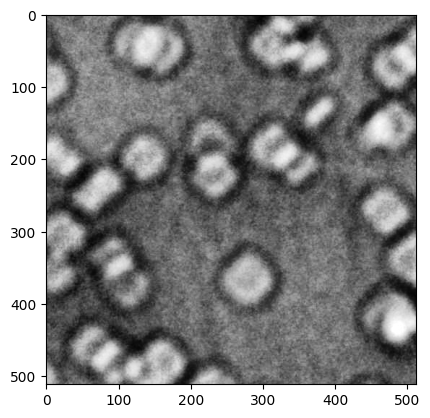

In [ ]:
plt.imshow(train_img[0], cmap='gist_gray')

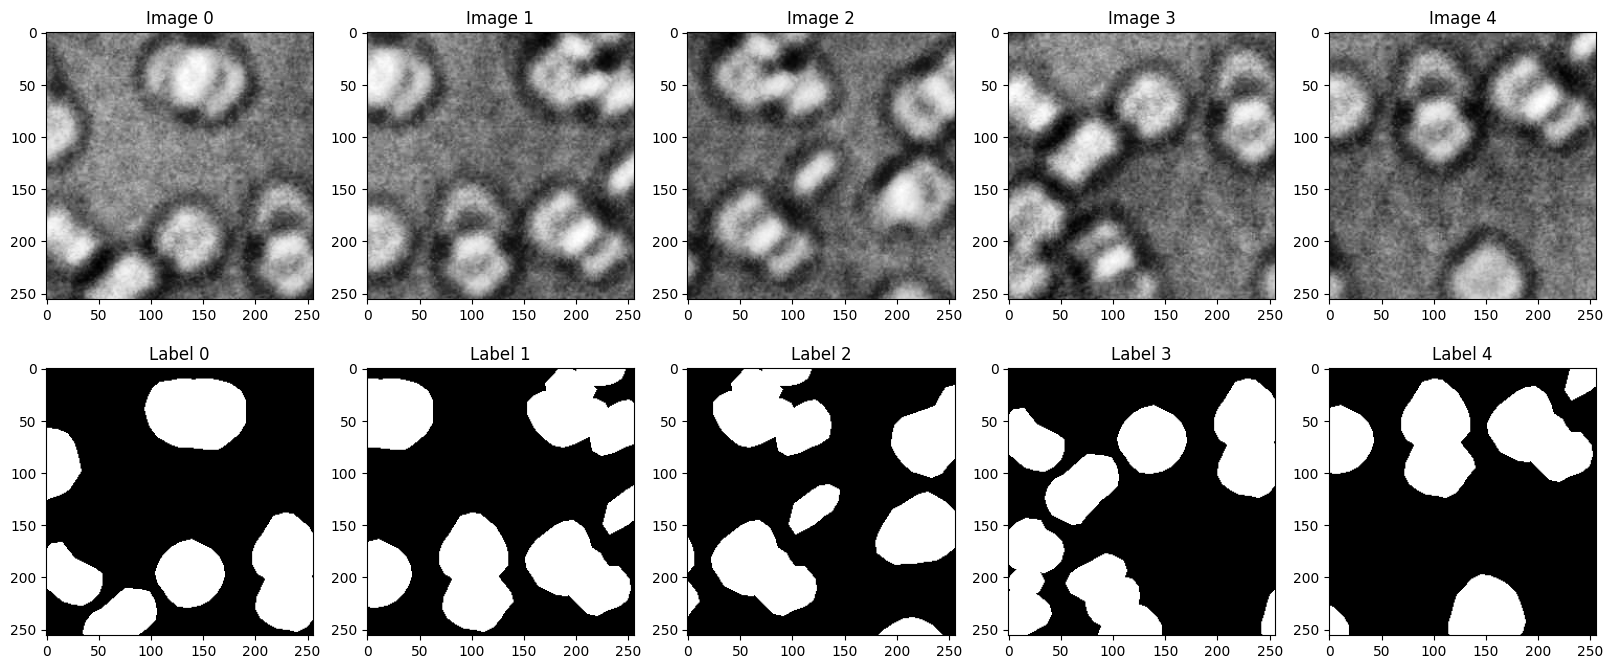

In [ ]:
fig = plt.figure(figsize=(20, 8))
for i in range(1, 6):   
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(train_img_patches[i-1, ...], cmap='gist_gray')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(train_lab_patches[i-1, ...], cmap='gist_gray')
    ax.set_title('Label ' + str(i-1))

In [ ]:
zoom = 1.3 # zoom factor
poisson_noise = [30, 40] # P noise range (scaled units)
gauss_noise = [0, 200] # G noise range (scaled units)
blur = [1, 50] # Blurring range (scaled units)
contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
jitter = [0, 50]
rotation=True
background=True
imaug = aoi.transforms.seg_augmentor(
    nb_classes=1, 
    salt_and_pepper=salt_and_pepper)
images_all, labels_all = imaug(torch.from_numpy(train_img_patches[:, np.newaxis, ...]), 
                               torch.from_numpy(train_lab_patches[:, np.newaxis, ...]), seed=6)

0.9383260011672974 0.022026438266038895 1 0


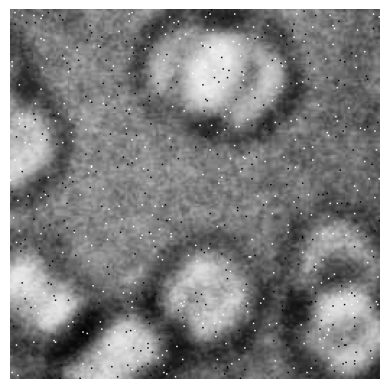

In [ ]:
print(train_img_patches[0].max(), train_img_patches[0].min(), train_lab_patches[0].max(), train_lab_patches[0].min())
fig, ax = plt.subplots(1, 1)
i = 0
#ax[0].axis('off')
#ax[0].imshow(train_img_patches[i], cmap='gist_gray')
ax.axis('off')
ax.imshow(images_all[i, 0, ...], cmap='gist_gray')
#ax[2].axis('off')
#ax[2].imshow(labels_all[i, 0, ...], cmap='gist_gray')